# Task Description

Film Junky Union, a new community for classic film fans is developing a system to filter and categorize movie reviews. Its main mission is to train a model to automatically detect negative reviews. We will use IMBD's *dataset* of film reviews with polarity labeling to create a model that can classify positive and negative reviews. This model must have at least an F1 score of 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides better quality graphics on a HiDPI screen

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is for using progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
df_reviews.shape

(47331, 17)

In [9]:
df_reviews.duplicated().sum()

0

In [10]:
df_reviews.isnull().sum().sort_values(ascending=False)

average_rating     2
votes              2
tconst             0
ds_part            0
pos                0
sp                 0
rating             0
review             0
genres             0
title_type         0
is_adult           0
runtime_minutes    0
end_year           0
start_year         0
original_title     0
primary_title      0
idx                0
dtype: int64

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the steps above and reading the data taken from the file /datasets/imdb_reviews.tsv', it is known that the file has 17 columns and 47331 rows. There are no duplicate values, but there are null values ​​in the dataframe.
Then perform Data Preprocessing with the following steps:

- Removed unnecessary features
- Added other features to get a better score
- The target is categoric, so this is a Classification Task
     
</div>

## EDA

Check the number of movies and reviews over the years.

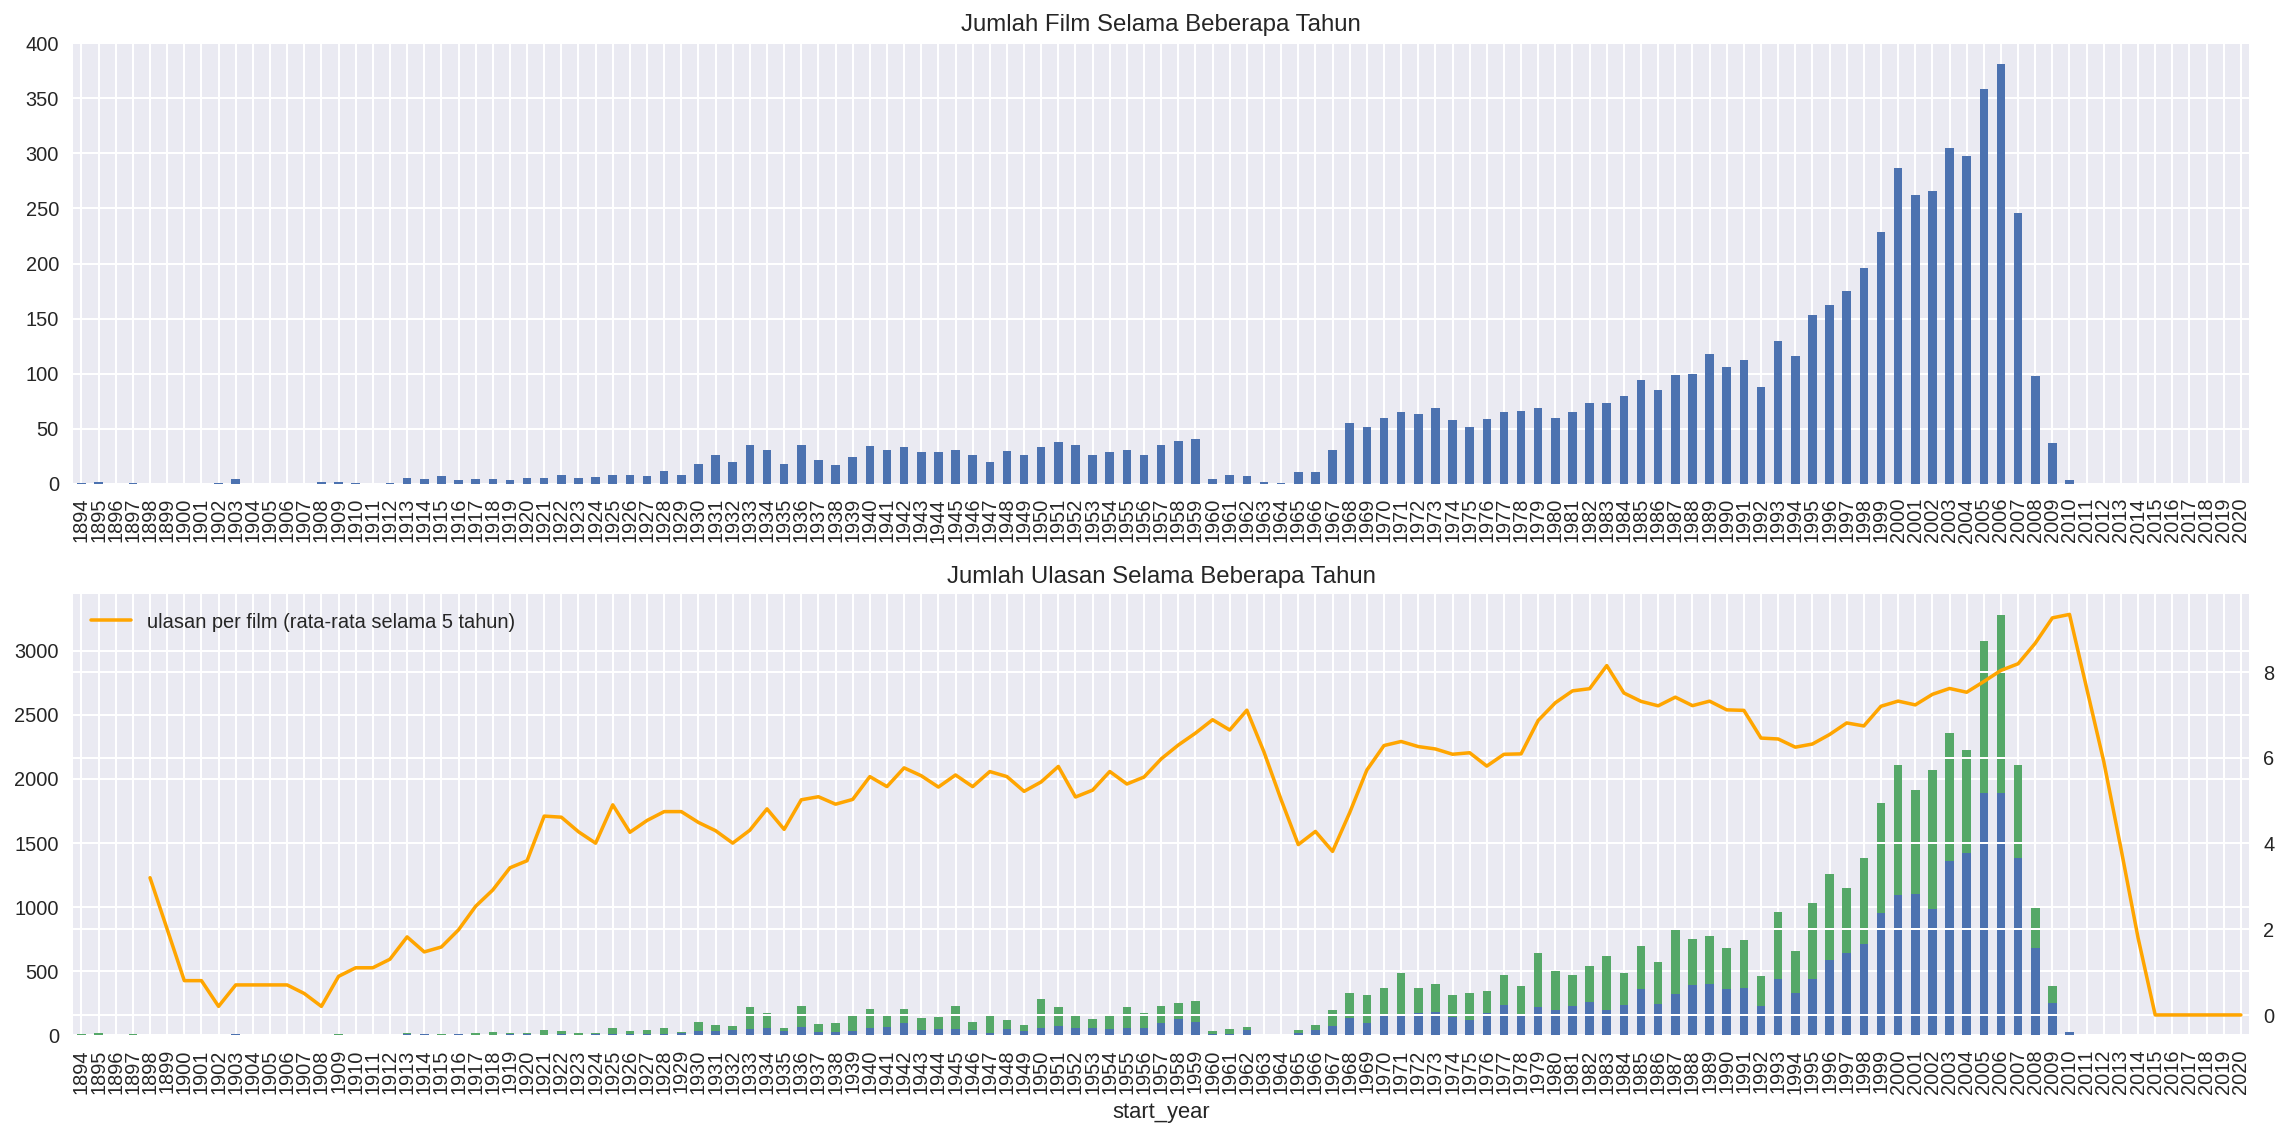

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Check the distribution of number of reviews per movie with proper count and KDE (just to see how it differs from exact count)

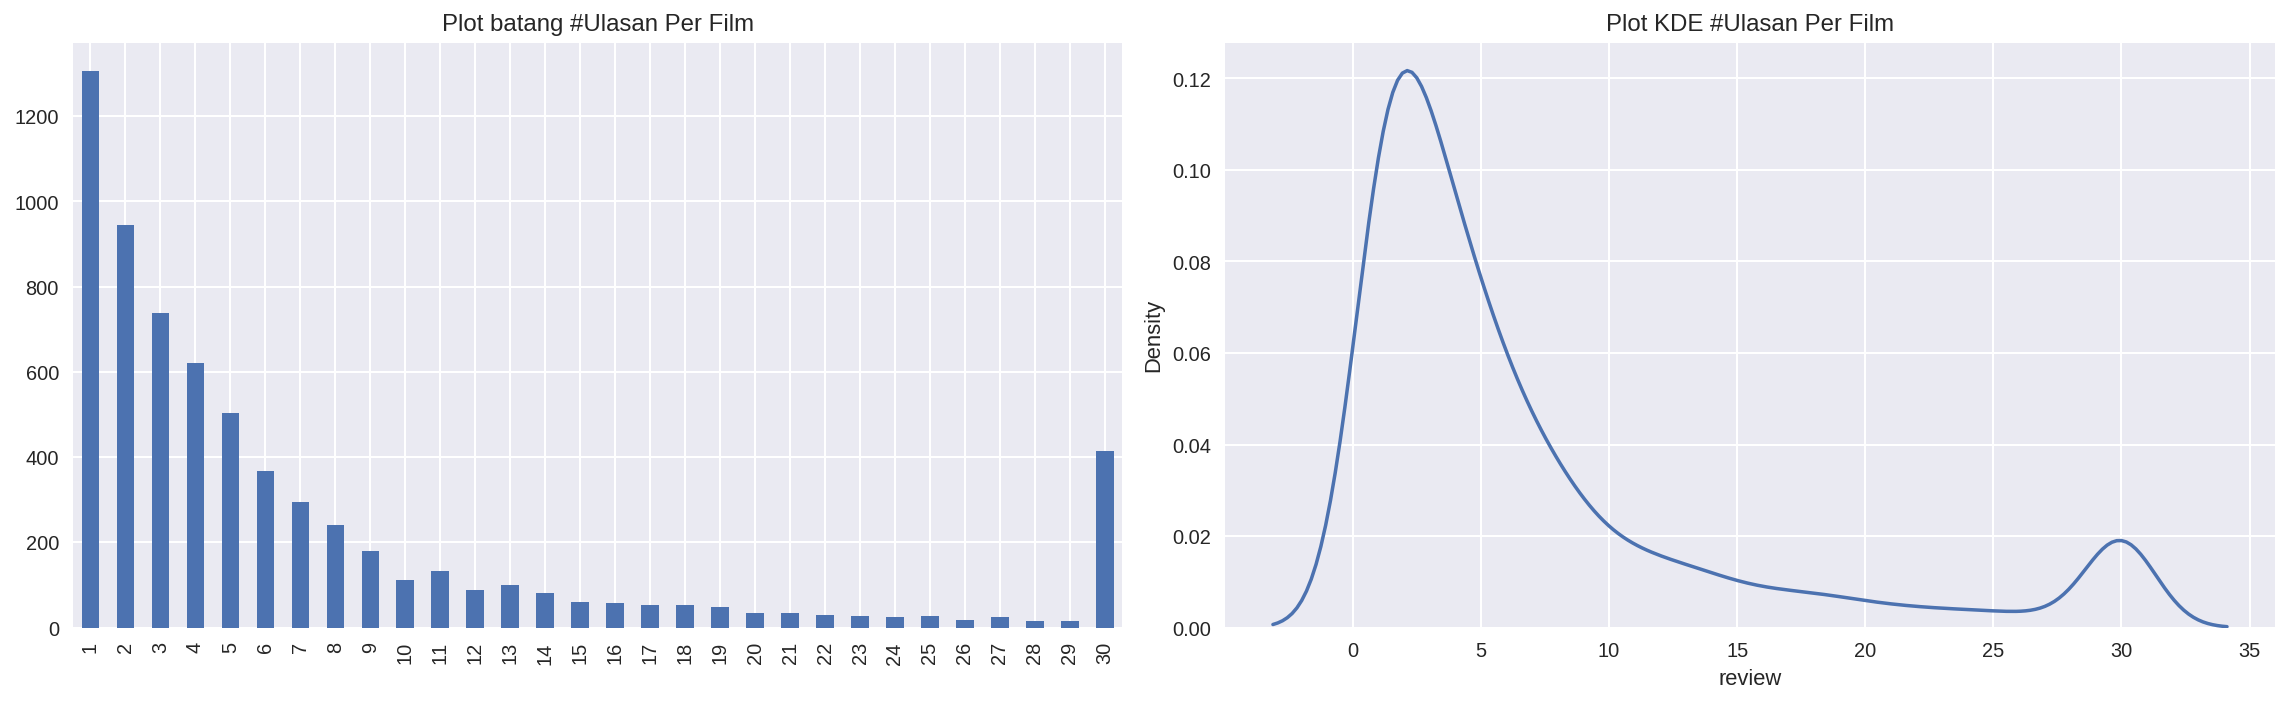

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [13]:
df_reviews.groupby('tconst')['review'].count().value_counts().max()

1307

In [14]:
df_reviews.groupby('tconst')['review'].count().value_counts().min()

16

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
For 1 film there are a maximum of 1307 reviews, and a minimum of 16 reviews.
     
</div>

In [15]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

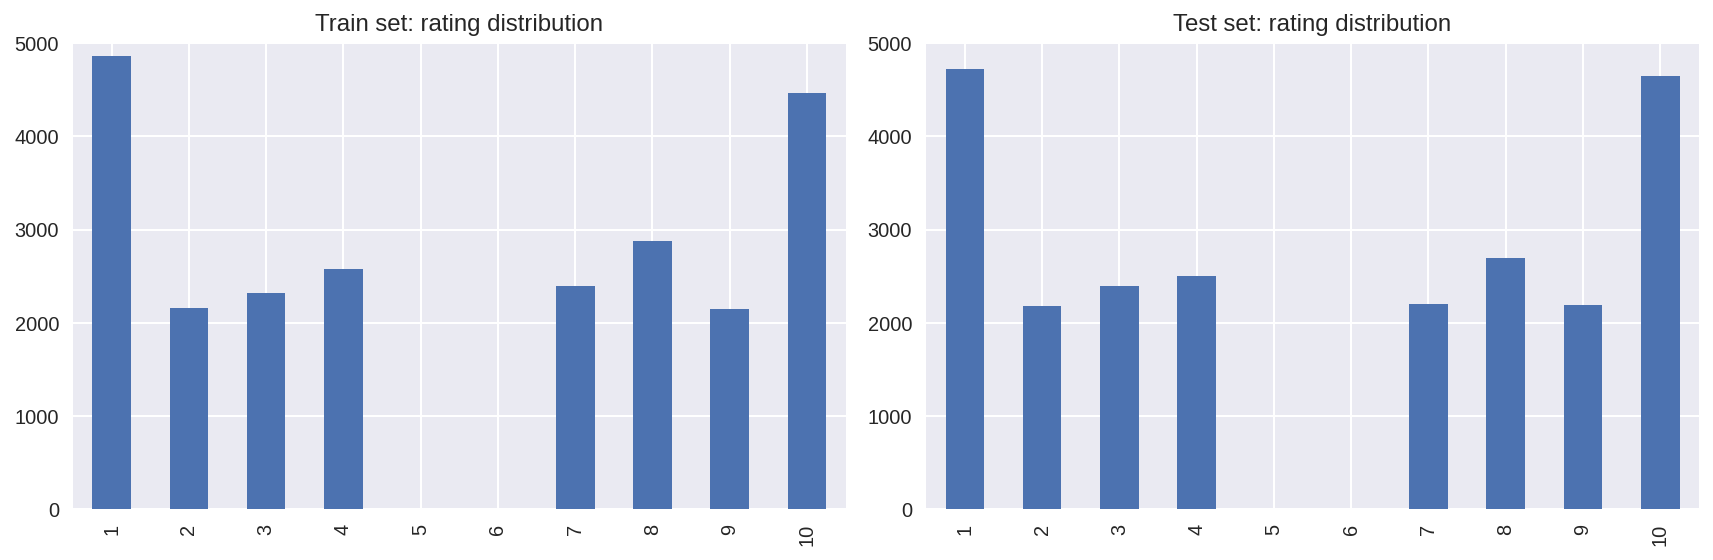

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: rating distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: rating distribution')

fig.tight_layout()

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The distribution of ratings on the train set and test set is very similar
     
</div>

Distribution of negative and positive reviews over the years for two sections of the *dataset*

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


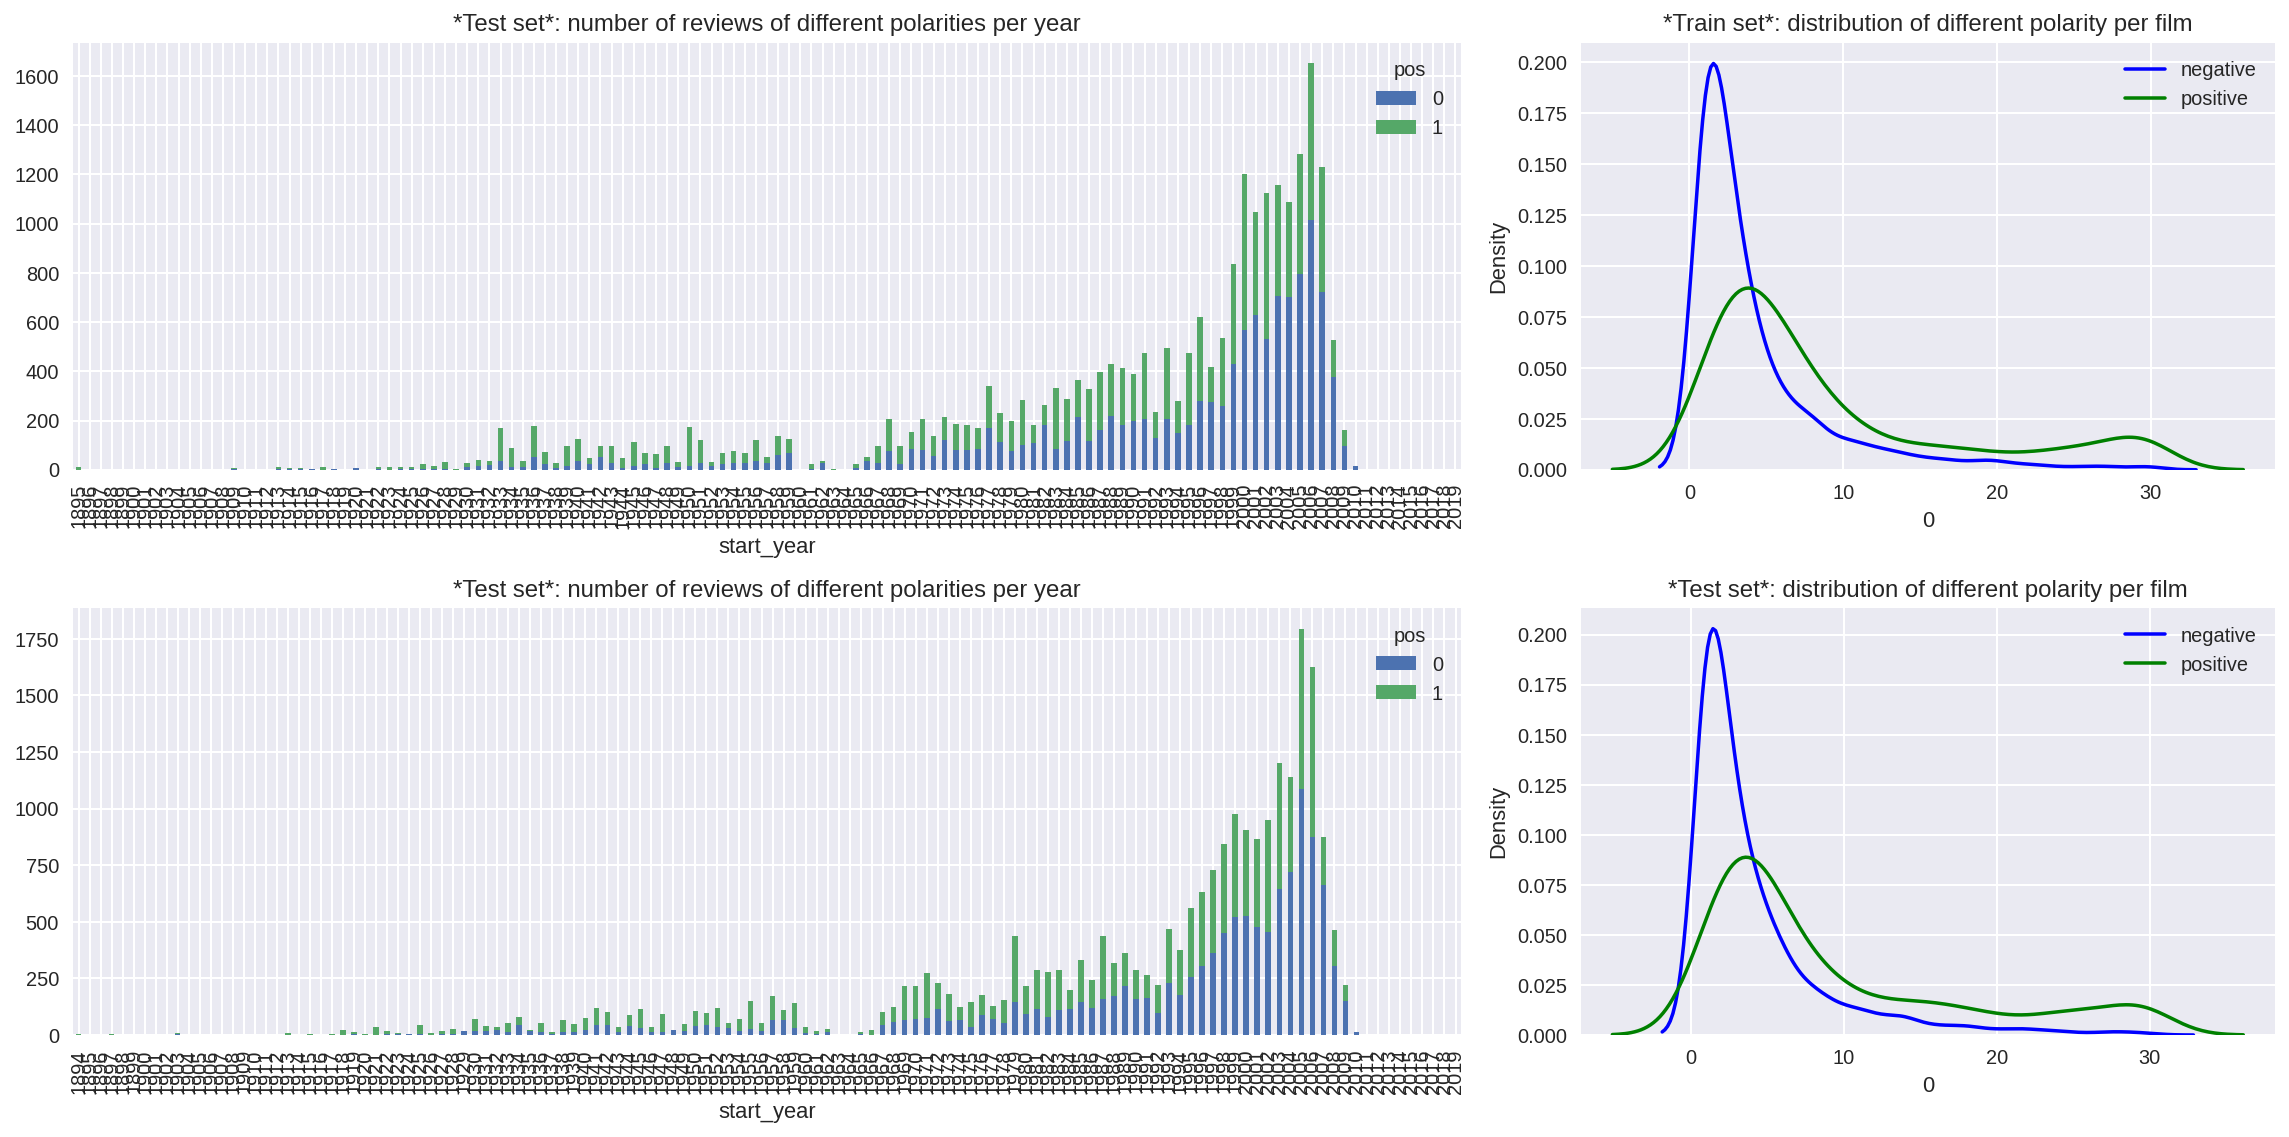

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribution of different polarity per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Test set*: distribution of different polarity per film')

fig.tight_layout()

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The distribution of positive and negative reviews of the two datasets is also very similar, this means that the model trained in the train set predicts correctly in the test set.
</div>

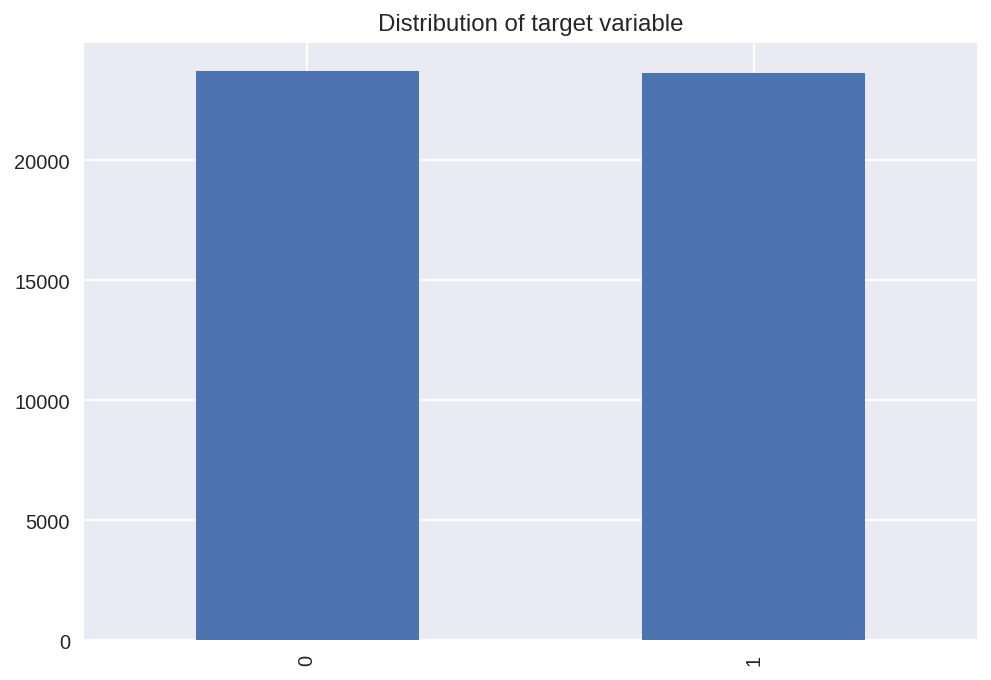

In [18]:
df_reviews['pos'].value_counts().plot(kind='bar')
plt.title('Distribution of target variable');

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Classes for positive and negative reviews are also balanced.
</div>

## Evaluation Procedure

Generate usable evaluations for all models in this task on a regular basis

In [19]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats

## Normalization

We assume all models below accept text in lowercase and without numbers, punctuation, etc.

In [20]:
def clean_data(data):
    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

In [21]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_data)
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

## Split Data Train / Test

Fortunately, the entire *dataset* has been divided into *train/test*. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']

X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']

print(X_train.shape)
print(X_test.shape)

(23796,)
(23535,)


## Working with Models

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


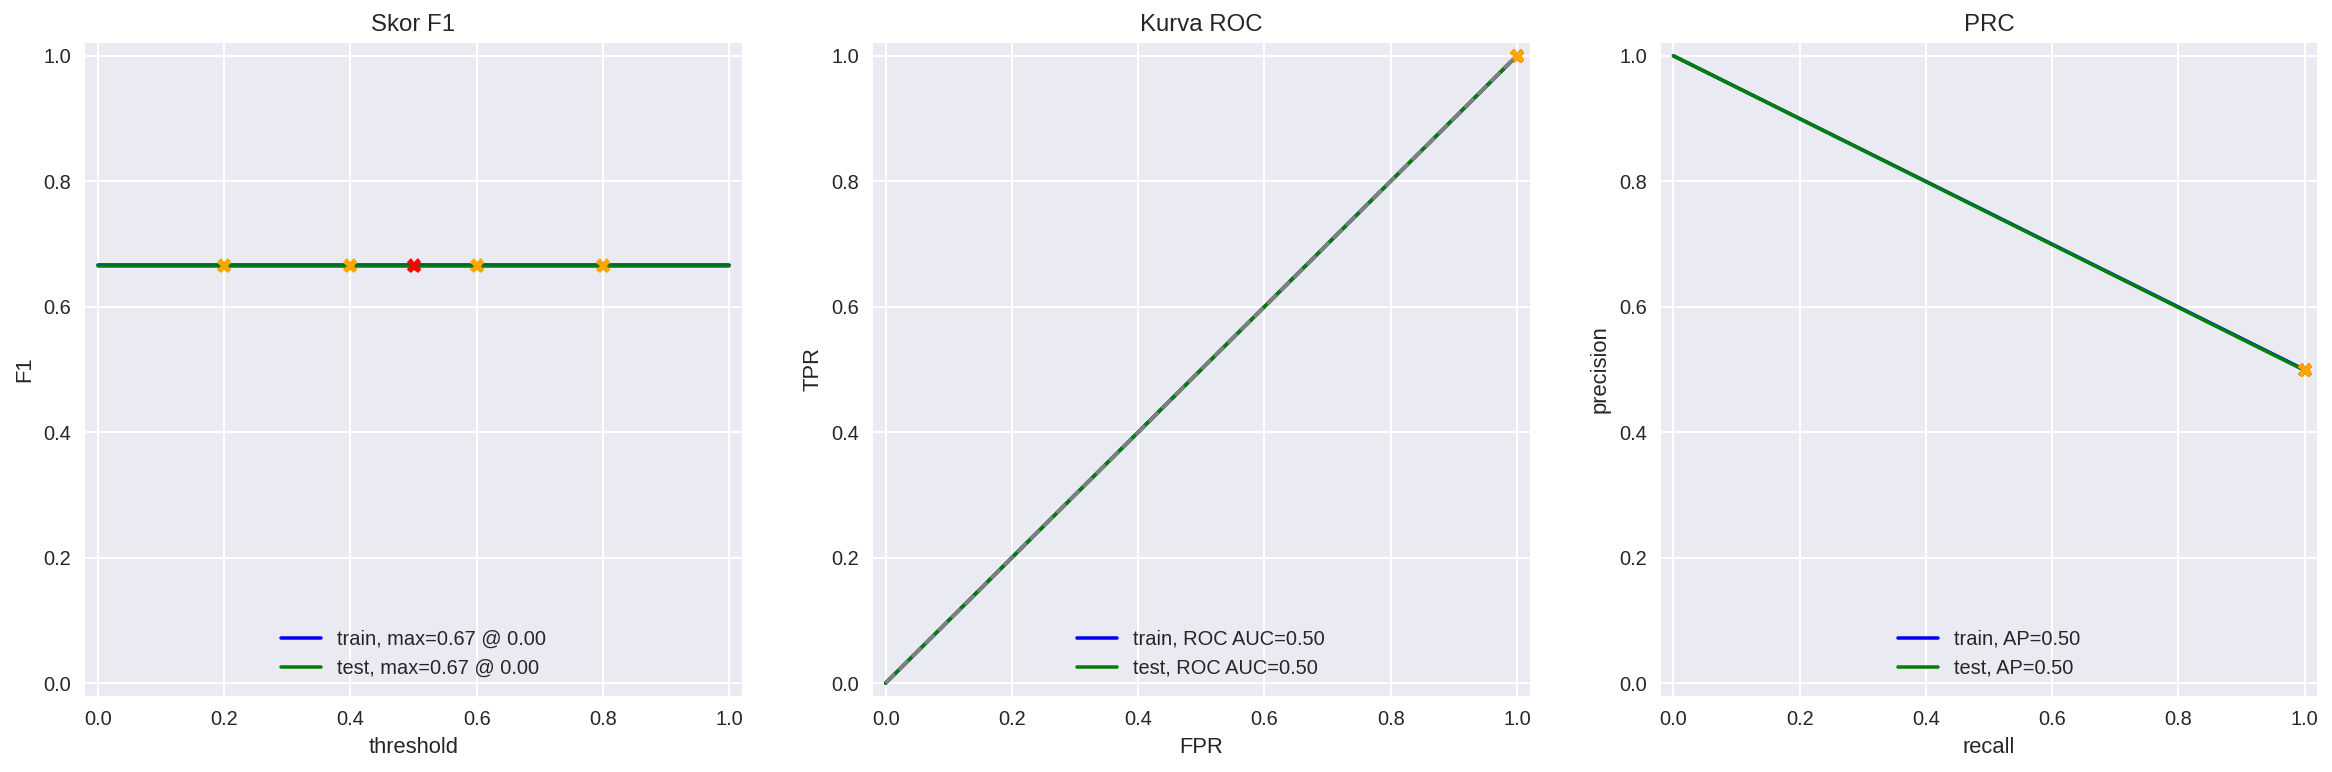

In [25]:
test_f1_model_1 = evaluate_model(model_dummy, X_train, y_train, X_test, y_test)

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The result of the dummy F1 score model is 0.67, still below the threshold of 0.85.
</div>

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [26]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [27]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tfidf_train = count_tf_idf.fit_transform(X_train)
tfidf_test = count_tf_idf.transform(X_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
model_2 = LogisticRegression(random_state=12345, solver='liblinear')
model_2.fit(tfidf_train, y_train)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


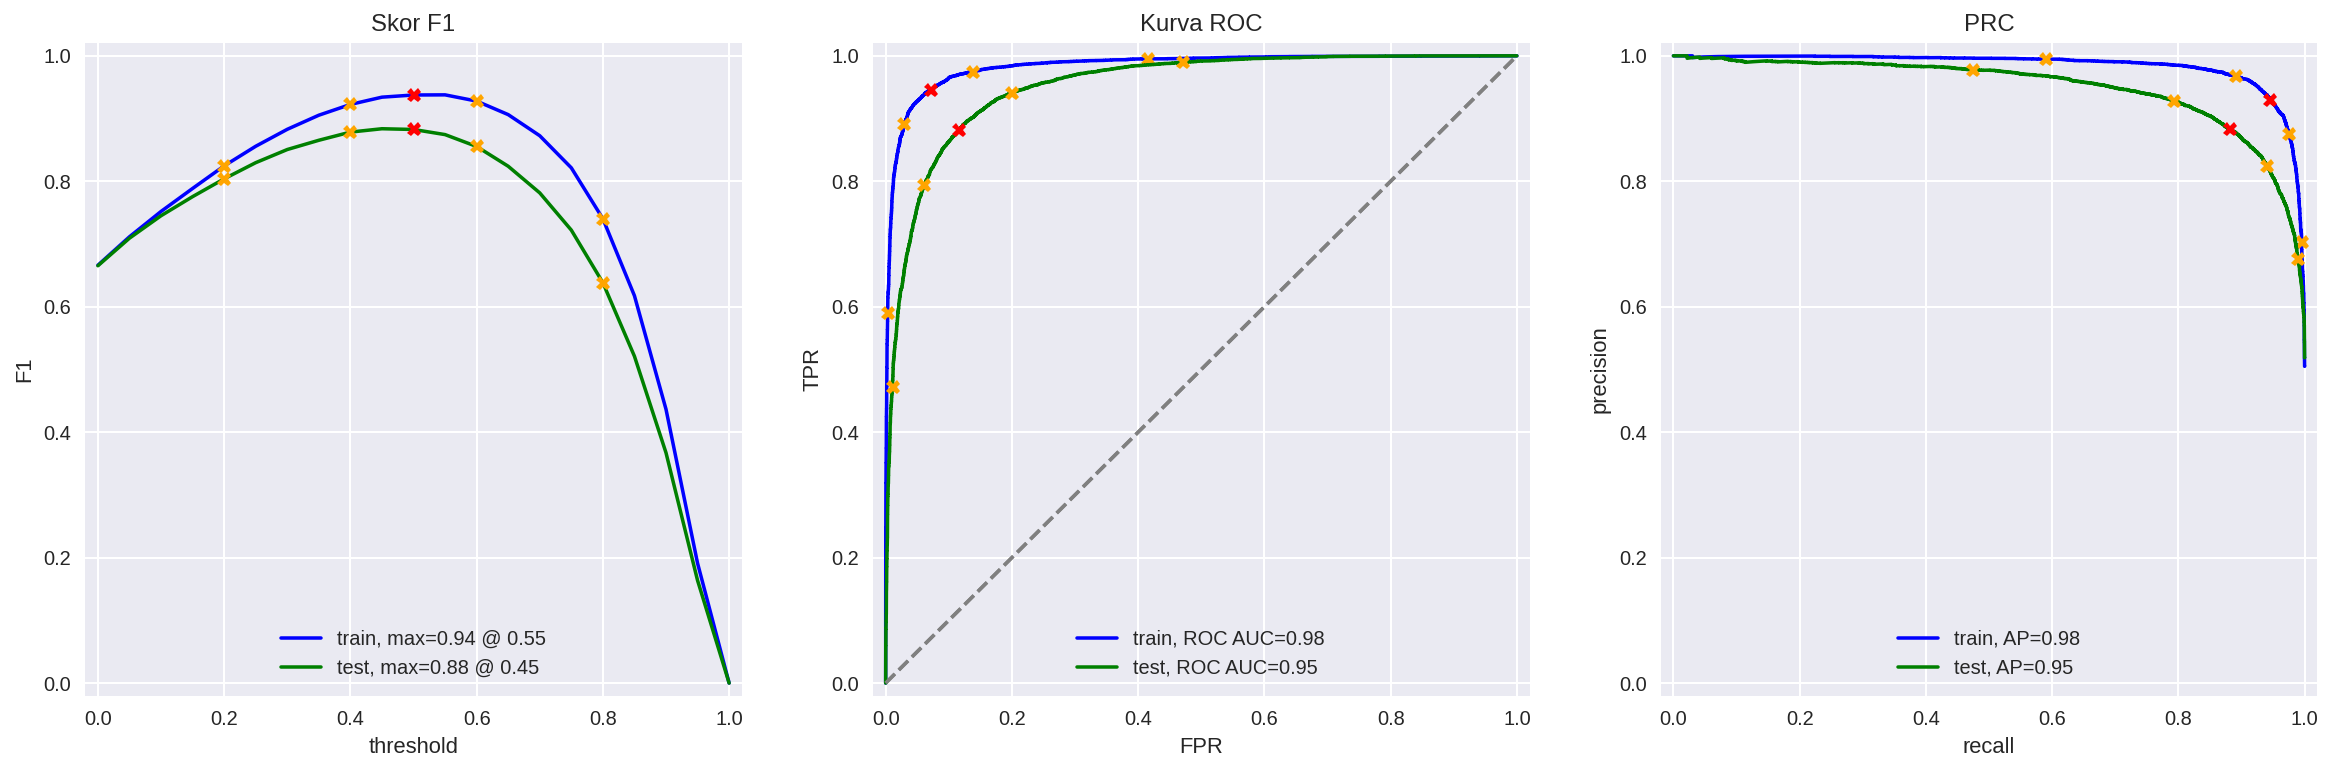

In [29]:
#evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)
test_f1_model_2 = evaluate_model(model_2, tfidf_train, y_train, tfidf_test, y_test)

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The Logistic Regression model with NLTK is better than the Dummy Model with an F1 score of 0.88
</div>

### Model 3 - spaCy, TF-IDF dan LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
#corpus = df_reviews['review']
#corpus_preprocessed = corpus.progress_apply(text_preprocessing_3)

In [33]:
#corpus_preprocessed

In [34]:
df_reviews_train['review_spacy'] = X_train.apply(lambda x: text_preprocessing_3(x))

In [35]:
df_reviews_train['review_spacy'] 

0        the pakage imply that warren beatty and goldie...
1        how the hell do they get this make present its...
7        this true story of carlson 's raider be more o...
8        should have be title ' balderdash ' little in ...
9        the movie ' gung ho ' the story of carlson 's ...
                               ...                        
47253    o my gosh just give I a minute to breath this ...
47254    I can not tell you all how much I love this mo...
47255    legend of zu be possibly the most exciting mov...
47256    this movie be well do on so many level that I ...
47257    as a history nut who be particularly intereste...
Name: review_spacy, Length: 23796, dtype: object

In [36]:
df_reviews_test['review_spacy'] = X_test.apply(lambda x: text_preprocessing_3(x))

In [37]:
df_reviews_test['review_spacy']

2        there be no real story the film seem more like...
3        um a serious film about troubled teen in singa...
4        I be totally agree with garryjohal from singap...
5        this be the first movie I 've see from singapo...
6        yes non singaporean 's can not see what be the...
                               ...                        
47326    this be another of my favorite columbo it spor...
47327    talk about be bore I get this expect a fascina...
47328    I never think I would say this about a biopic ...
47329    spirit and chaos be an artistic biopic of miya...
47330    I 'll make this brief this be a joy to watch i...
Name: review_spacy, Length: 23535, dtype: object

In [38]:
count_tf_idf2 = TfidfVectorizer()
spacy_X_train = count_tf_idf2.fit_transform(df_reviews_train['review_spacy'])
print(spacy_X_train.shape)

spacy_X_test = count_tf_idf2.transform(df_reviews_test['review_spacy'])
print(spacy_X_test.shape)

(23796, 59276)
(23535, 59276)


In [39]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(spacy_X_train, y_train)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


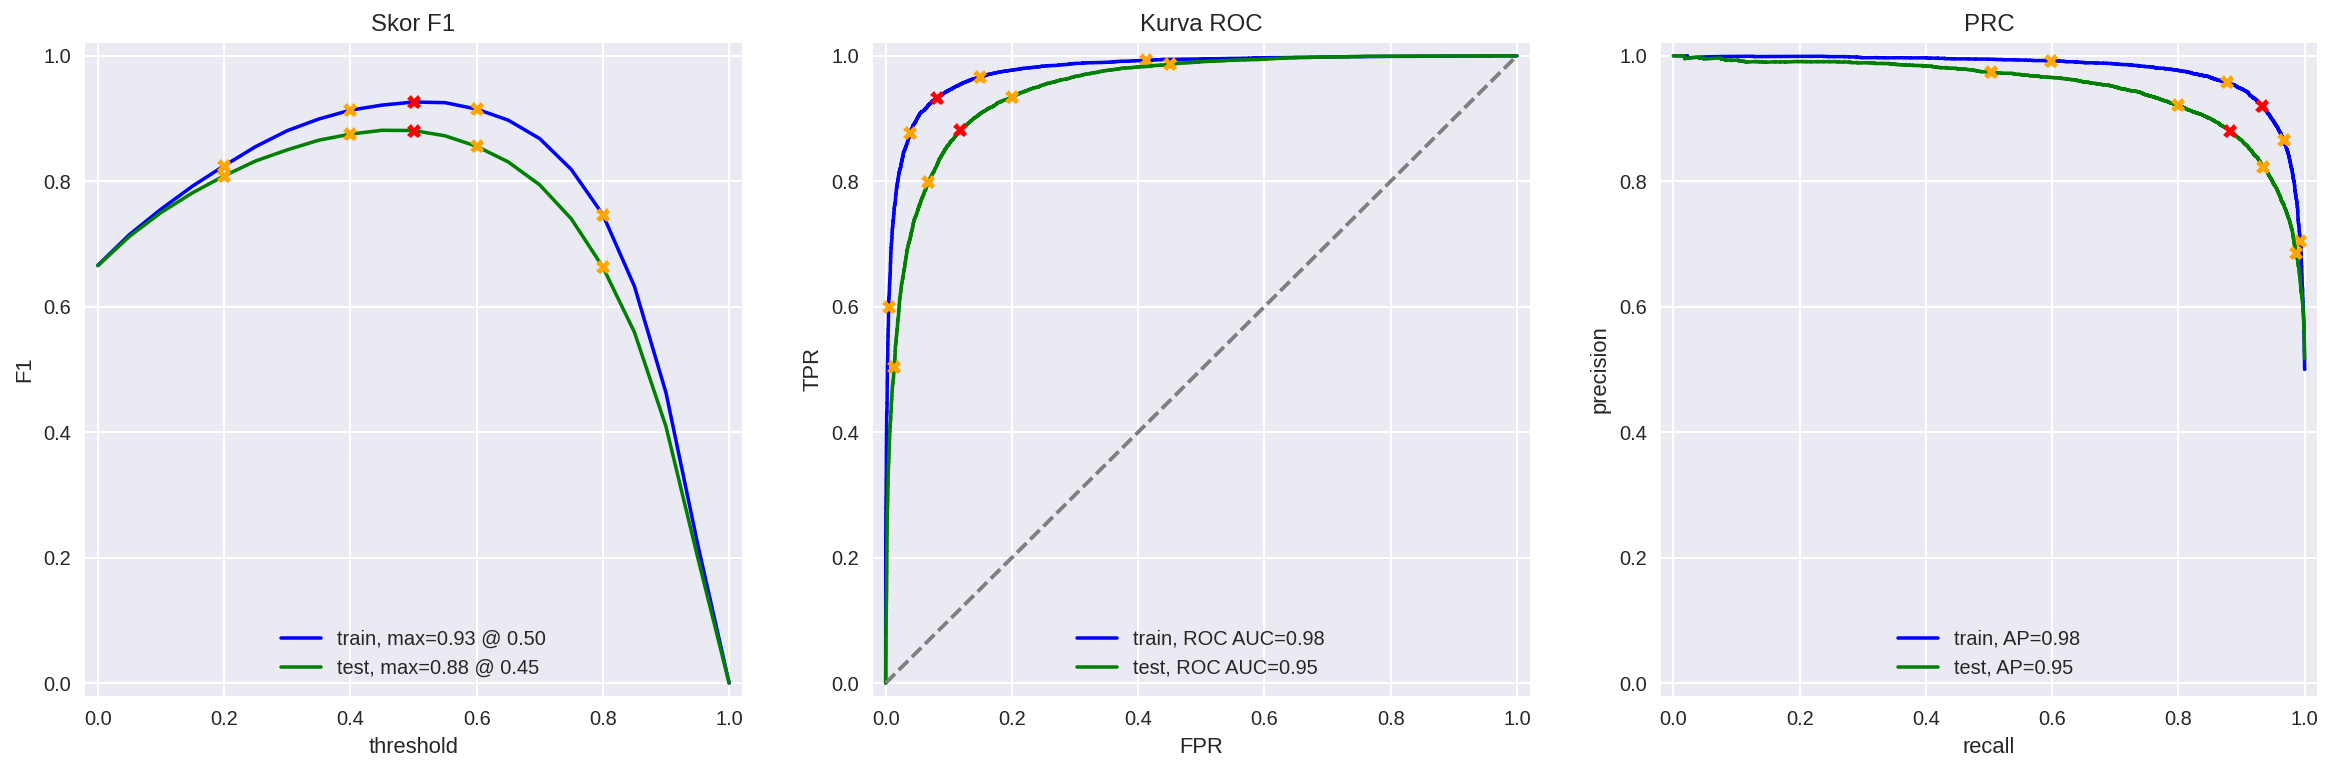

In [40]:
test_f1_model_3 = evaluate_model(model_3, spacy_X_train, y_train, spacy_X_test, y_test)

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The Logistic Regression Model with Spacy has the same results as using NLTK, namely 0.88, but it takes quite a long time.
</div>

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [41]:
from lightgbm import LGBMClassifier

In [42]:
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(spacy_X_train, y_train)

LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


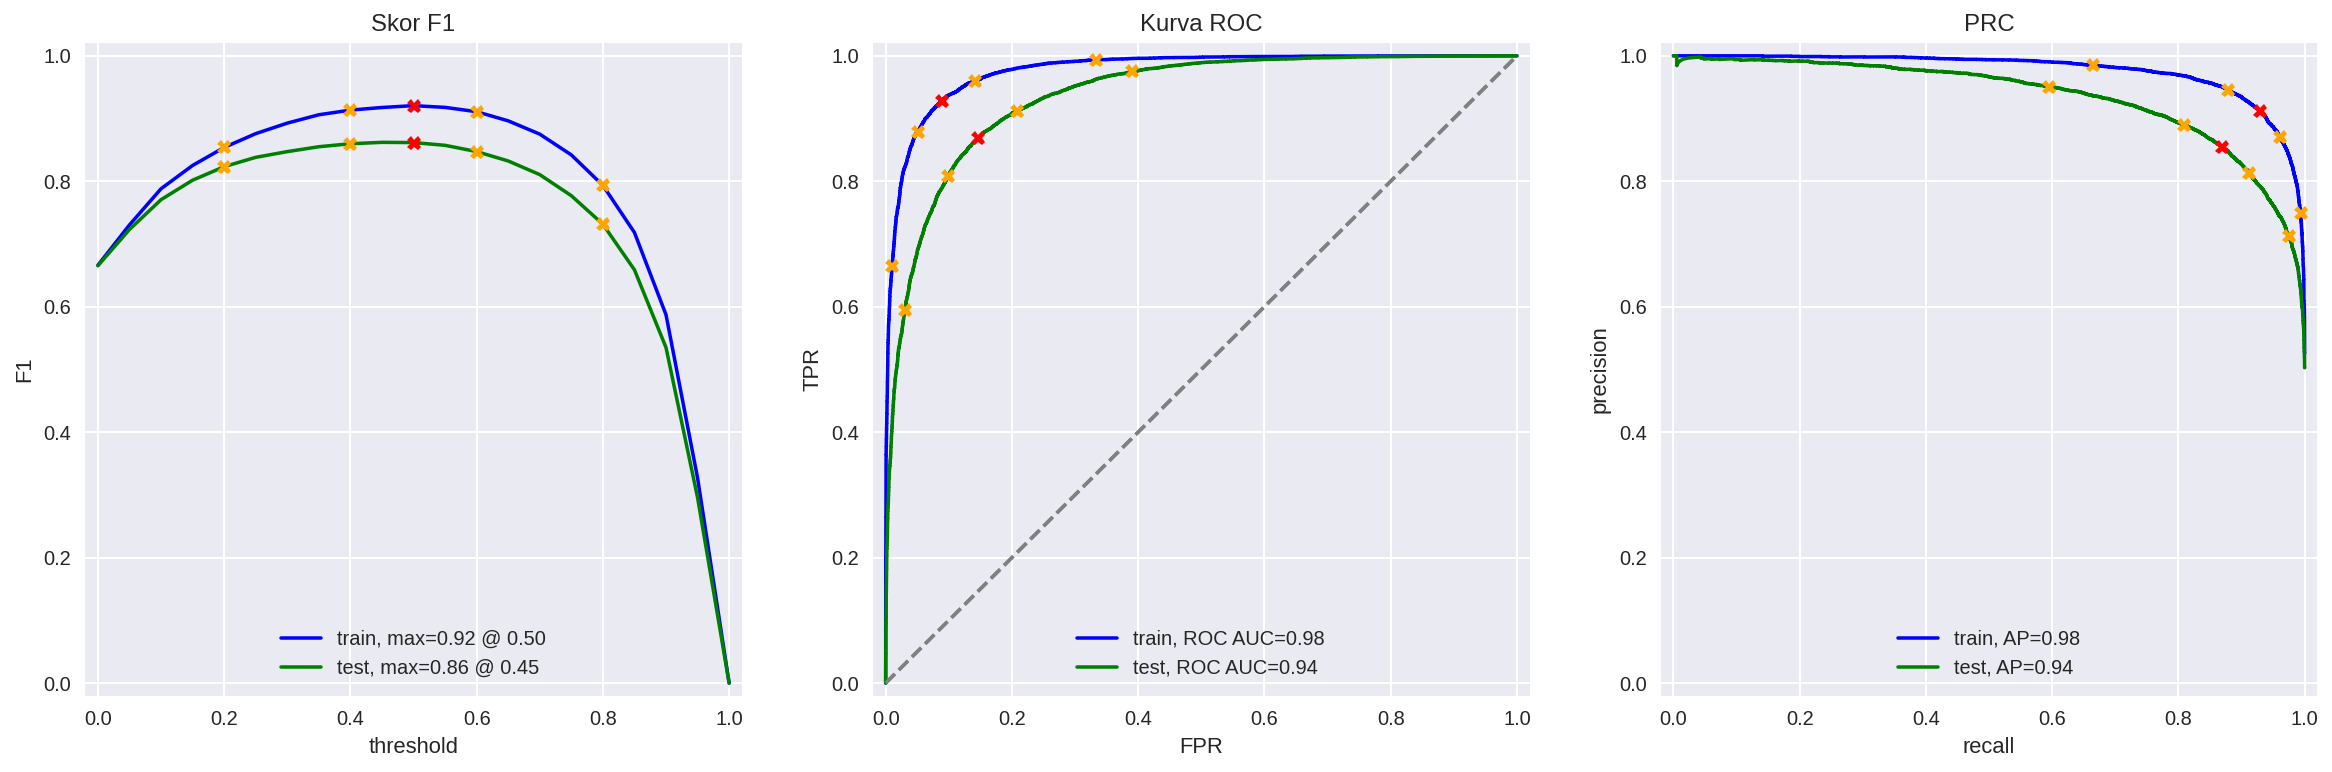

In [43]:
test_f1_model_4 = evaluate_model(model_4, spacy_X_train, y_train, spacy_X_test, y_test)

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The LGBM model with Spacy is lower than the previous 2 models because the F1 Score is only 0.86
</div>

###  Model 9 - BERT

In [44]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    #ids_list = []
    #attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    
    # <masukkan kode di sini untuk ids_list dan attention_mask_list>
    
    #if force_device is not None:
    #    device = torch.device(force_device)
    #else:
    #    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    #model.to(device)
    #if not disable_progress_bar:
    #    print(f'Gunakan {perangkat} perangkat.')
    
    # dapatkan embedding dalam batch 

    #embeddings = []

    #for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        #ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch 
            
        #with torch.no_grad():            
        #    model.eval()
        #    batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        #embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    #return np.concatenate(embeddings)

In [ ]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [ ]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

### Model Results

In [ ]:
model1 = test_f1_model_1['test']['F1']
model2 = test_f1_model_2['test']['F1']
model3 = test_f1_model_3['test']['F1']
model4 = test_f1_model_4['test']['F1']

In [ ]:
models = pd.DataFrame({
    'Model': ['baseline', 'NLTK+TFIDF+LR', 'spaCy+TFIDF+LR', 'spaCy+TFIDF+LGBM'],
    'Score': [model1, model2, model3, model4]})
sorted_by_score = models.sort_values(by='Score', ascending=False)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5)) 
sns.barplot(x='Score', y = 'Model', data = sorted_by_score, color = 'g')
values = models.sort_values(by='Score', ascending=False)['Score']
plt.title('Comparison of Machine Learning Algorithms')
plt.xlabel('F1 score on test data (%)')
plt.ylabel('Model')
for counter, value in enumerate(values):
    axs.text(value - 0.1, counter, round(value,2), color='white', va='center', fontsize=10, fontweight='bold')
;

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Of all the training models, the first model, namely NLTK with Logistic Regression, is the best with a score of 0.88. Spacy and Logistic Regressin have the same F1 score but it takes a long time.
</div>

## Reviews

In [ ]:
my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: text_preprocessing_3(x))

my_reviews

In [ ]:
my_reviews.shape

### Model 2

In [ ]:

texts = my_reviews['review_norm']


my_reviews_pred_prob = model_2.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

In [ ]:
model2_pred = model_2.predict(count_tf_idf.transform(texts))
model2_pred

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
4 out of 8 reviews of model 2 predicted positive.
</div>

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

In [ ]:
model3_pred = model_3.predict(count_tf_idf2.transform(texts))
model3_pred

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
4 out of 8 reviews of model 3 predicted positive.
</div>

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf2
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

In [ ]:
model4_pred = model_4.predict(count_tf_idf2.transform(texts))
model4_pred

<div style="background-color:rgba(0, 255, 172, 0.07)"
     

8 out of 8 reviews of model 4 predicted positive.
     
</div>

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

1. Initialization
2. Load Data
From the steps above and reading the data taken from the file /datasets/imdb_reviews.tsv', it is known that the file has 17 columns and 47331 rows. No duplicate values,
but there are null values ​​in the dataframe but they are not significant.
3. EDA
-Distribution of Number of Films Over the Years in 1967 increased to 2006.
The distribution is similar to the number of reviews. In addition, the distribution of negative and positive reviews in the train set and test tests is also similar.
4. Evaluation Procedure
- At this stage a function is created to find out the f1 score, ROC, and PRC for each model that will be tested later.
5. Normalization
- Normalize data by removing digits, punctuation and making lower case in all text.
6. Separation of Train / Test
- The data has been divided into 2 Train Sets and Test Sets
7. Models
- Of all the training models, the first model, namely NLTK with Logistic Regression, is the best with a score of 0.88.
Above the threshold on this project is 0.85. Spacy and Logistic Regressin have the same F1 score but it takes a long time.

- A test has also been carried out for the new review text.
- The preferred model, namely Model 2 (NLTK with Logistic Regression) predicts 4 out of 8 reviews correct.
- However Model 4 (LGBM with Spacy) predicted a correct 8 out of 8 Reviews.